# Demonstration notebook

This notebook presents how to make use of the most relevant bits of code provided as well as step by step explication of the implementation of Algorithm 2.

## Package upload

In this case we upload all the functions implemented in the files "clustering.py", "generic_functions.py" and "other_clustering_functions.py", contained in the folder "Package". The entry sys.path contains the directory containing the folder Package.

In [1]:
import numpy as np

import sys
sys.path += ['/Package/']  ### Specify the directory where the Package is
from generic_functions import *
from clustering import *
from other_clustering_functions import *

import warnings
warnings.filterwarnings("ignore")

## Generating or uploading  a graph $\mathcal{G}$

### DC-SBM synthetic graph

We provide here below an example of how to generate a sparse adjacency matrix using our codes. For pictorial porpused we use a small $n$ and a large average degree. The obtained adjacency matrix is in sparse representation.

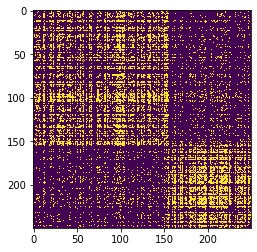

In [8]:
'''Initializations parameters'''


n = 250 # size of the networks (number of nodes)
n_clusters = 2 # number of clusters (k)

''' This bit of code needs to create the vector theta'''

theta = (np.random.uniform(3,10,n))**(4) # inizializing to a power law distribution
theta = theta/np.mean(theta) # imposing the first moment E[theta] = 1
phi = np.mean(theta**2) # computing the second momentE[theta^2] = phi

''' We now proceed creating the matrix Pi'''

fraction = np.random.normal(1/n_clusters,1/(2*n_clusters), n_clusters) # vector pi
fraction = fraction/sum(fraction) # normalization of Tr(Pi)
Pi = np.diag(fraction)

''' We build the matrix C'''

c_out = 30 # average value of the off-diagonal elements
c = 100 # average degree
fluctuation = 1/n_clusters # the off-diagonal elements will be distributed as N(c_out,c_out*fluctuation)


C_matrix = matrix_C(c_out, c, fluctuation, fraction)

''' We now define the Label vector '''

label = np.zeros(n) # label vector
for i in range(n_clusters):
    label[int(n*sum(fraction[:i])):int(n*sum(fraction[:i+1]))] = i
label = label.astype(int)


'''Finally we construct the adjacency matrix'''

A = adj(C_matrix,c, label, theta) # creation of adjacency matrix

plt.imshow(A.A)
plt.show();

### Upload and use the datasets

We here provide an example on how to upload and use the datasets in gml format and in txt format

In [34]:
''' gml format'''

karate = nx.read_gml('datasets/karate.gml', label = 'id') # upload the file
A_karate = nx.adjacency_matrix(karate) # create the adjacency matrix
karate = np.array([[u,v] for u, v in karate.edges]) # create the adjacency matrix in it edge list representation

''' txt format '''

nutella = np.loadtxt('datasets/p2p-Gnutella08.txt') # upload the file
nutella = nutella.astype(int) # this contains the edge list

''' Now to obtain the giant component '''

net = nutella # type here the name of the network
G = nx.Graph()
G.add_edges_from(net)
G = max(nx.connected_component_subgraphs(G), key=len) # this reduces the graph to its largest connected component
A = nx.adjacency_matrix(G) # this obtains the corresponding adjacency matrix

## Algorithm 2

We here detail how to use Algorithm 2 as well as commenting its building blocks.

### Use of Algorithm 2

In [35]:
cluster = community_detection(A)

Number of clusters detected : 4

Estimating zeta : 02
Labels estimated


The function only needs $A$ as an input. Other possible input are
* n_max (scalar) : maximal number of possible classes to look for during the estimation. If not specified set equal to 80
* real_classes (array of size n) : vector containing the true labels of the network. If not specified set to None
* n_clusters (scalar) : number of clusters k. If not specified it will estimate it
* eps (scalar) : precision rate. If not specified set to machine precision
* projection (True/False) : performs the projection on the unitary hypersphere in dimension k, before the k-means step. If not else specified, set to true

The output of cluster are

* cluster.estimated_labels (array of size n) : vector containing the estimated labels
* cluster.n_clusters (scalar) : estimated values of k used in the k-means step
* cluster.overlap (scalar) : overlap with respect to the known partition
* cluster.modularity (scalar) : modularity of the estimated partition
* cluster.zeta_v (array of size k) : vector containing the values of zeta_p


For example

In [36]:
print('The number of clusters is ' + str(cluster.n_clusters) + '\n'
'The modularity is ' + str(cluster.modularity))

The number of clusters is 4
The modularity is 0.40051945827462415


### Building blocks of Algorithm 2

In [37]:
d = np.array(np.sum(A,axis = 0))[0] # degree vector
n = len(d) # size of the network

''' This function computes the spectral radius of the matrix B'''

rho = find_rho_B(A) # r = rho(B)

''' We proceed to estimate the number of communities according to Subroutine 1'''

n_clusters = 1 
D_rho_05 = scipy.sparse.diags((d + (rho -1)*np.ones(n))**(-1/2), offsets = 0) 
L_rho = D_rho_05.dot(A).dot(D_rho_05) # symmetric reduced Laplacian at tau = rho(B)-1
flag = 0
while flag == 0:
    vrho = scipy.sparse.linalg.eigsh(L_rho, k = n_clusters + 1 , which='LA', return_eigenvectors=False) # largest eigenvalues of L_tau
    if min(vrho)> 1/np.sqrt(rho) + np.finfo(float).eps: #  if informative
        n_clusters += 1
    else:
        flag = 1
        
''' When we get at this point n_cluster is the value estimated according to Subroutine 1 

The function find_zeta outputs the values of zeta_p and the informative eigenvectors according to Subroutine 2.

'''

zeta_p, X = find_zeta(A, rho, n_clusters, eps = np.finfo(float).eps) # find the zeta vector and  the corresponding informative  matrix


''' Given the matrix X, we now proceed with the projection on the unitary hypersphere.'''

for i in range(n):
    X[i] = X[i]/np.sqrt(np.sum(X[i]**2)) # normalize the rows  of X

    
''' We finally perform the k-means step on X'''    
    
kmeans = KMeans(n_clusters = n_clusters) # perform kmeans on the informative eigenvector
kmeans.fit(X)
estimated_labels = kmeans.predict(X)

print('\nDone')



Estimating zeta : 02
Done
